In [1]:
# regularized_jump_model_demo.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import optuna
from typing import Optional, List, Dict, Tuple
import yfinance as yf

# Add the current directory to Python path to import your modules
sys.path.append('.')

# Import your custom modules
from Datafactory import normalized, load_feature_data
from Jump_New import RegularizedJumpModel, PenaltyType, sweep_k_and_plot_scores

# Optional: If you get import errors, use this alternative approach
import importlib.util
import os

## DataLoading

In [2]:
def load_your_data(file_path):
    """
    Load your feature data from Excel file
    """
    try:
        df = load_feature_data(file_path, 0)
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    
df = load_your_data('top_features_df.csv')
performance = []
df = df.dropna(axis=0, how='any')
sample_data = normalized(df)

Data loaded successfully. Shape: (421, 41)
Columns: ['IPNCONGD', 'INDPRO', 'IPNMAT', 'IPB51222S', 'IPFUELS', 'UEMPMEAN', 'USFIRE', 'UEMP27OV', 'UEMP15OV', 'CES0600000008', 'HOUST', 'AMDMUOx', 'DPCERA3M086SBEA', 'UMCSENTx', 'BUSINVx', 'M2SL', 'DTCTHFNM', 'TOTRESNS', 'NONREVSL', 'BOGMBASE', 'EXJPUSx', 'EXSZUSx', 'TB3MS', 'FEDFUNDS', 'COMPAPFFx', 'CUSR0000SAS', 'WPSFD49207', 'DDURRG3M086SBEA', 'WPSID62', 'CUSR0000SAD', 'S&P div yield', 'S&P PE ratio', 'GDP_diff', 'CAPE', 'MOVE Index', 'VIX Index', 'USGG2YR Index', 'LUACOAS Index', '.0210 F Index', 'SPX_realized_vol_20d', 'SPX_realized_vol_60d']


In [3]:
spx = yf.download("^GSPC", start = '1990-01-01', end = '2025-04-01', auto_adjust=True, progress=False)
prices = spx["Close"].dropna()

d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

(<Figure size 1400x320 with 1 Axes>, <Figure size 900x650 with 1 Axes>)

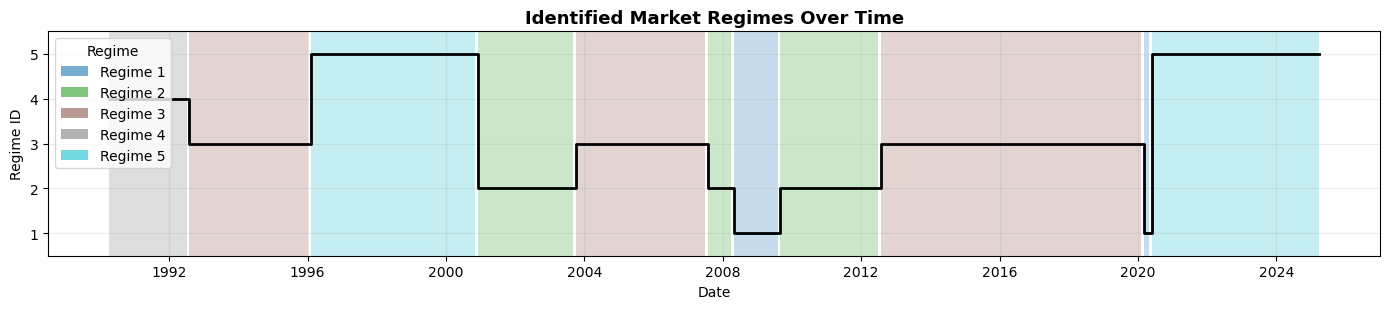

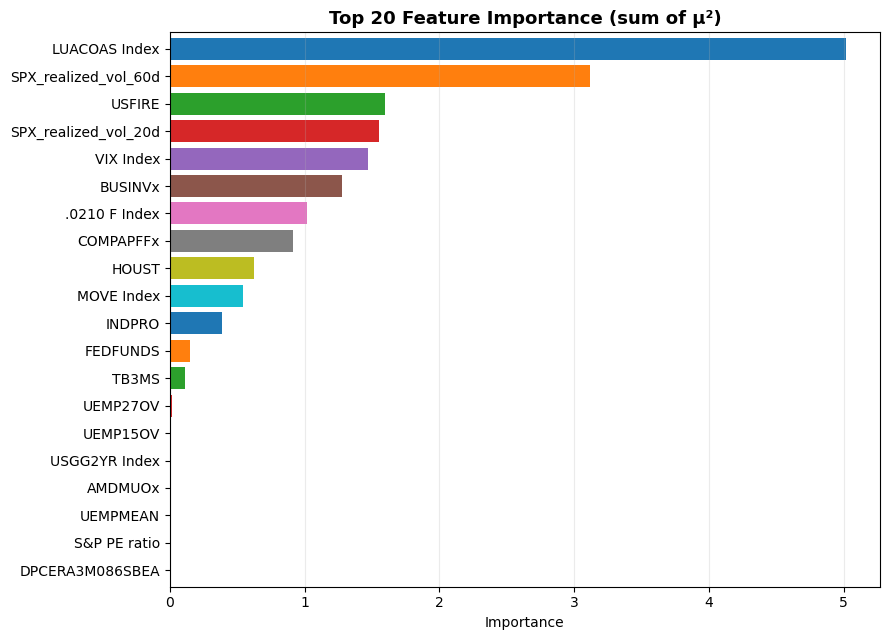

In [41]:
model = RegularizedJumpModel(
    k=5,           # Number of states
    lmbd=20,     # Jump penalty parameter
    gamma=0.1,   # Regularization parameter
    penalty="lasso"  # Penalty type: "l0", "lasso", "ridge", "group_lasso"
)
model.input_data(sample_data)
model.initialize()
model.calibrate()
model.visualize()

In [37]:
print(model.regime_series)

Date
1990-04-01    4
1990-05-01    4
1990-06-01    4
1990-07-01    4
1990-08-01    4
             ..
2024-12-01    5
2025-01-01    5
2025-02-01    5
2025-03-01    5
2025-04-01    5
Name: regime, Length: 421, dtype: int64


In [6]:
df = load_your_data("df_1M_ret.csv")
print(df)
df_returns = df.loc[:, ['Russell 1000', 'US Agg Bond', 'Gold', 'Dollar']]

Data loaded successfully. Shape: (427, 13)
Columns: ['Russell 1000', 'Russell 1000 Value', 'Russell 1000 Growth', 'MSCI World ex USA Index (DM ex-US Equities)', 'MSCI EM Index (EM Equities)', 'US Agg Bond', 'US Short-term Treasury', 'US Long-term Treasury', 'US IG Corporate Bond', 'US HY Corporate Bond', 'Global Agg ex-US Bond USD Hedged', 'Gold', 'Dollar']
            Russell 1000  Russell 1000 Value  Russell 1000 Growth  \
Date                                                                
1990-02-28      0.011514            0.019618             0.004243   
1990-03-31      0.022369            0.007378             0.037740   
1990-04-30     -0.027945           -0.041467            -0.014519   
1990-05-31      0.089062            0.076765             0.100899   
1990-06-30     -0.007778           -0.025656             0.008843   
...                  ...                 ...                  ...   
2025-04-30     -0.006767           -0.031830             0.017406   
2025-05-31      0.0

In [39]:
df_returns

,Russell 1000,US Agg Bond,Gold,Dollar
Date,,,,
1990-02-28,0.011514,0.003236,-0.017709,0.022299
1990-03-31,0.022369,0.000737,-0.096149,0.012441
1990-04-30,-0.027945,-0.009162,-0.002035,0.012608
1990-05-31,0.089062,0.029608,-0.012780,-0.003310
1990-06-30,-0.007778,0.016045,-0.029886,-0.009962
...,...,...,...,...
2025-04-30,-0.006767,0.003929,0.060014,-0.032633
2025-05-31,0.062435,-0.007159,-0.007420,-0.006179
2025-06-30,0.049380,0.015375,0.003021,-0.019829


In [40]:
result = model.summarize_regime_table_minimal({'Russell 1000':df_returns['Russell 1000'], 'US Agg Bond':df_returns['US Agg Bond'], 'Gold':df_returns['Gold'], 'Dollar':df_returns['Dollar']})
print(result)

                                 Russell 1000                    US Agg Bond  \
1              -0.017 ± 0.087 (ann vol 0.302)  0.005 ± 0.015 (ann vol 0.053)   
2              -0.001 ± 0.050 (ann vol 0.172)  0.006 ± 0.010 (ann vol 0.034)   
3               0.010 ± 0.027 (ann vol 0.095)  0.004 ± 0.010 (ann vol 0.034)   
4               0.009 ± 0.044 (ann vol 0.152)  0.010 ± 0.011 (ann vol 0.038)   
5               0.014 ± 0.046 (ann vol 0.160)  0.002 ± 0.015 (ann vol 0.052)   
ANOVA p-value                          0.0174                         0.0166   

                                         Gold                          Dollar  
1               0.007 ± 0.071 (ann vol 0.246)   0.008 ± 0.029 (ann vol 0.101)  
2               0.017 ± 0.051 (ann vol 0.176)  -0.001 ± 0.017 (ann vol 0.059)  
3               0.004 ± 0.040 (ann vol 0.139)   0.002 ± 0.014 (ann vol 0.050)  
4              -0.006 ± 0.034 (ann vol 0.118)   0.003 ± 0.015 (ann vol 0.050)  
5               0.003 ± 0.042 (ann vol 

In [ ]:
# def run_complete_analysis_with_optuna(
#     data: pd.DataFrame,
#     base_model,
#     random_state: int = 42,
#     calibrate_max_iter: int = 10,
#     # pass through to optuna_tune_with_bootstrap:
#     lambda_range: tuple = (1e-1, 1e2),
#     gamma_range: tuple = (1e-1, 1e2),
#     penalty_candidates: List[str] = ("lasso", "l0", "ridge", "group_lasso"),
#     n_boot: int = 10,
#     n_trials: int = 60,
#     sampler: Optional[optuna.samplers.BaseSampler] = None,
#     pruner: Optional[optuna.pruners.BasePruner] = None,
#     storage: Optional[str] = None,
#     study_name: Optional[str] = None,
#     n_startup_trials: int = 10,
# ) -> dict:
#     """
#     End-to-end pipeline:
#       1) Tune hyperparameters with optuna_tune_with_bootstrap (across all percents).
#       2) Rebuild a model with best params.
#       3) Initialize, restrict to best_percent, calibrate.
#       4) Compute metrics and feature importance; return a results bundle.
#     """

#     def _pick_nearest_key(keys, target):
#         """Pick exact or nearest percent key from `keys`."""
#         if target in keys:
#             return target
#         try:
#             t = float(target)
#             return min(((abs(float(k) - t), k) for k in keys), key=lambda x: x[0])[1]
#         except Exception:
#             return next(iter(keys))

#     def _score_solution(y_np: np.ndarray, mu, s: np.ndarray,
#                         lmbd: float, gamma: float, model_like) -> dict:
#         """Compute original-data cost components and total. Accepts mu as DF or ndarray."""
#         if mu is None or s is None:
#             return {"recon_error": np.inf, "jumps": np.inf, "reg": np.inf, "total_cost": np.inf}
#         mu_arr = mu.to_numpy() if isinstance(mu, pd.DataFrame) else np.asarray(mu)
#         recon_error = float(np.sum((y_np - mu_arr[s - 1]) ** 2))
#         jumps = int(np.sum(s[1:] != s[:-1]))
#         reg = float(model_like.compute_penalty(mu))  # model can handle DF or ndarray
#         total_cost = recon_error + float(lmbd) * jumps + float(gamma) * reg
#         return {"recon_error": recon_error, "jumps": jumps, "reg": reg, "total_cost": total_cost}

#     def _compute_importance_by_feature(mu, data: pd.DataFrame, model_like) -> pd.Series:
#         """
#         Per-feature importance = sum over states of mu^2 for each feature.
#         Returns a pd.Series indexed by feature names.
#         """
#         if isinstance(mu, pd.DataFrame):
#             return (mu ** 2).sum(axis=0)  # columns are feature names
#         # ndarray path
#         mu_arr = np.asarray(mu)
#         names = getattr(model_like, "feature_names", None)
#         if names is None:
#             try:
#                 names = list(data.columns)
#             except Exception:
#                 names = [f"f{j}" for j in range(mu_arr.shape[1])]
#         return pd.Series(np.sum(mu_arr ** 2, axis=0), index=names)

#     results: dict = {}

#     # 1) Tuning
#     print("\n[1] Tuning with optuna_tune_with_bootstrap ...")
#     tuner = RegularizedJumpModel(k=base_model.k, lmbd=base_model.lmbd,
#                                  gamma=base_model.gamma, penalty=base_model.penalty)
#     tuner.input_data(data)
#     tune_out = tuner.optuna_tune_with_bootstrap(
#         lambda_range=lambda_range,
#         gamma_range=gamma_range,
#         penalty_candidates=list(penalty_candidates),
#         n_boot=n_boot,
#         max_iter=calibrate_max_iter,
#         n_trials=n_trials,
#         random_state=random_state,
#         sampler=sampler,
#         pruner=pruner,
#         storage=storage,
#         study_name=study_name,
#         n_startup_trials=n_startup_trials,
#     )

#     best_params = tune_out["best_params"]
#     best_percent = tune_out["best_percent"]
#     best_score = tune_out["best_score"]
#     print(f"   -> best_params   : {best_params}")
#     print(f"   -> best_percent  : {best_percent}")
#     print(f"   -> best_score    : {best_score:.6g}")

#     # 2) Build final model
#     print("\n[2] Building final model with tuned params ...")
#     final_model = RegularizedJumpModel(
#         k=base_model.k,
#         lmbd=best_params["lmbd"],
#         gamma=best_params["gamma"],
#         penalty=best_params["penalty"],
#     )

#     # 3) Initialize, restrict, calibrate
#     print("\n[3] Initializing and calibrating on full data ...")
#     final_model.input_data(data)
#     final_model.initialize(k=final_model.k, random_state=random_state)

#     chosen_key = _pick_nearest_key(final_model.initial_state.keys(), best_percent)
#     final_model.initial_state = {chosen_key: final_model.initial_state[chosen_key]}
#     calib = final_model.calibrate(max_iter=calibrate_max_iter)
#     best_res = calib[chosen_key]

#     # Persist best solution on the model
#     final_model.mu = best_res["mu"]
#     final_model.state_seq = best_res["state_sequence"]

#     # 4) Score + feature importance
#     print("\n[4] Scoring final solution + computing feature importance ...")
#     Y = final_model.data.to_numpy()
#     metrics = _score_solution(
#         y_np=Y,
#         mu=best_res["mu"],
#         s=best_res["state_sequence"],
#         lmbd=final_model.lmbd,
#         gamma=final_model.gamma,
#         model_like=final_model,
#     )
#     importance_by_feature = _compute_importance_by_feature(best_res["mu"], data, final_model)

#     print("\nFinal Model Summary")
#     print("=" * 60)
#     print(f"  percent          : {chosen_key}")
#     print(f"  iterations       : {best_res['iterations']}")
#     # Report shape whether mu is DF or ndarray
#     mu_shape = best_res["mu"].shape if not isinstance(best_res["mu"], pd.DataFrame) \
#                else (best_res["mu"].shape[0], best_res["mu"].shape[1])
#     print(f"  mu shape         : {mu_shape}")
#     print(f"  lambda (lmbd)    : {final_model.lmbd}")
#     print(f"  gamma            : {final_model.gamma}")
#     print(f"  penalty          : {getattr(final_model.penalty, 'value', str(final_model.penalty))}")
#     print(f"  recon_error      : {metrics['recon_error']:.6g}")
#     print(f"  jumps            : {metrics['jumps']}")
#     print(f"  reg (penalty)    : {metrics['reg']:.6g}")
#     print(f"  TOTAL COST       : {metrics['total_cost']:.6g}")

#     # Print top-20 features by importance
#     print("\nTop 20 features by importance (sum of μ² across states):")
#     print(importance_by_feature.sort_values(ascending=False).head(20).to_string())

#     # Bundle outputs
#     results["tuning"] = {
#         "best_params": best_params,
#         "best_score": best_score,
#         "best_percent": best_percent,
#         "study": tune_out.get("study"),
#     }
#     results["final"] = {
#         "percent": chosen_key,
#         "mu": best_res["mu"],                          # DF or ndarray
#         "state_sequence": best_res["state_sequence"],
#         "iterations": best_res["iterations"],
#         "metrics": metrics,
#         "importance_by_feature": importance_by_feature,  # <-- added
#         "feature_importance_init": getattr(final_model, "feature_score", None),  # from initialize
#         "model": final_model,
#     }
#     return results


# print("Starting RJM analysis with Optuna tuning ...")
# out = run_complete_analysis_with_optuna(
#     data=df,
#     base_model=model,
#     random_state=42,
#     calibrate_max_iter=10,
#     n_boot=10,
#     n_trials=60,
# )

d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

(<Figure size 1400x320 with 1 Axes>, <Figure size 900x650 with 1 Axes>)

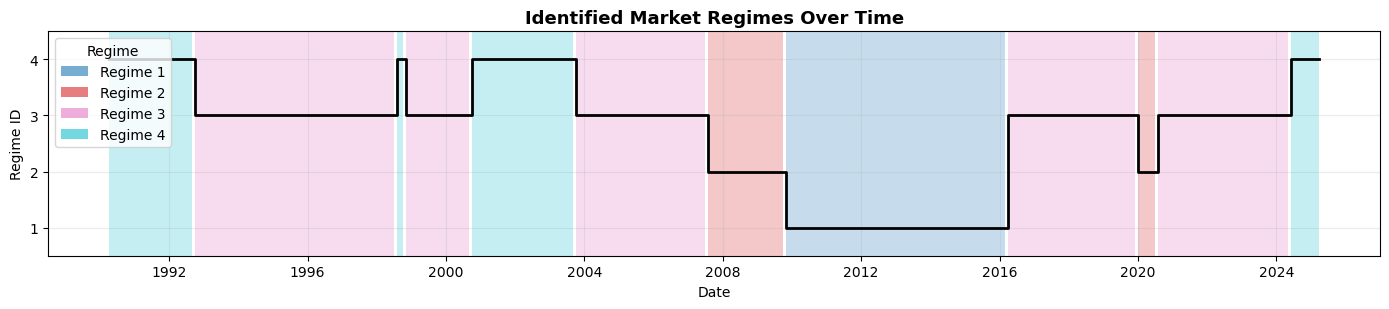

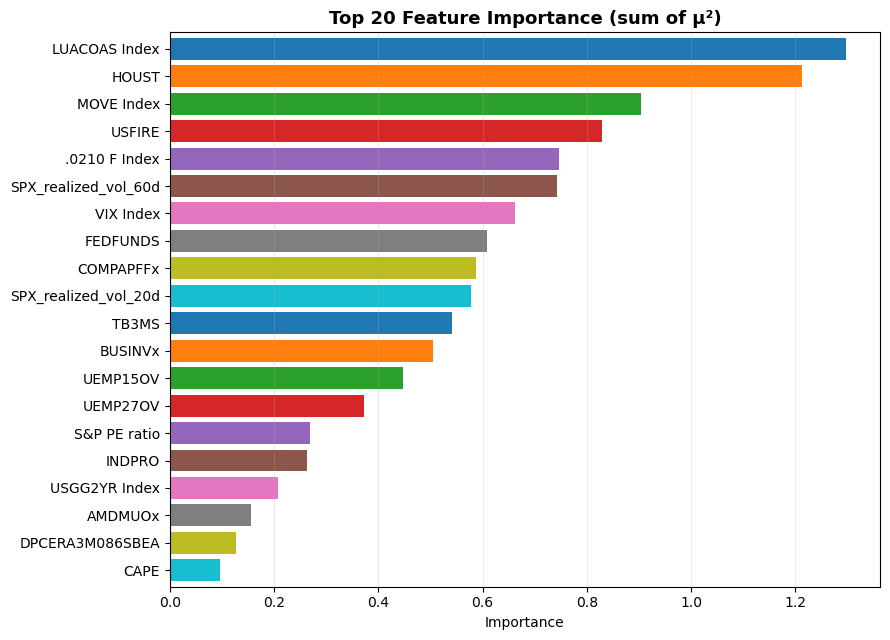

In [3]:
model = RegularizedJumpModel(
    k=4,           # Number of states
    lmbd=20,     # Jump penalty parameter
    gamma=0.1,   # Regularization parameter
    penalty="ridge"  # Penalty type: "l0", "lasso", "ridge", "group_lasso"
)

# Split data into in-sample (IS) and out-of-sample (OOS) sets
train_end_date = '2019-12-31'
oos_start_date = '2020-01-01'

# Ensure the data index is a datetime index
df.index = pd.to_datetime(df.index)

# Split the data
train_data = df[df.index <= train_end_date]
oos_data = df[df.index >= oos_start_date]

# Initialize and calibrate the model using in-sample data
model.input_data(train_data)
model.initialize()
model.calibrate()

IS_regime = model.regime_series

# Test the model on out-of-sample data
# Use the frozen parameters (mu and s from training)
oos_regimes = model.predict(oos_data)  # OOS data
OOS_regime = model.regime_series

model.regime_series = pd.concat([IS_regime, OOS_regime])
model.visualize()

d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

[K=2] score=16457.6001, iters=6, best%=1


d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

[K=3] score=16142.5253, iters=10, best%=50


d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

[K=4] score=16005.4143, iters=6, best%=25


d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

[K=5] score=16024.0893, iters=5, best%=50


d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Annaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

[K=6] score=15955.5253, iters=4, best%=50


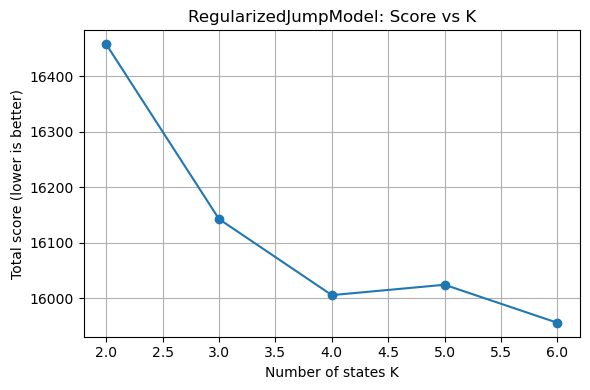

2    16457.600071
3    16142.525327
4    16005.414315
5    16024.089349
6    15955.525256
dtype: float64


In [6]:
scores = sweep_k_and_plot_scores(
    data=sample_data,
    lmbd=20.0,
    gamma=0.1,
    penalty="lasso",  # or PenaltyType.GROUP_LASSO
    k_values=(2,3,4,5,6),
    max_iter=10,
    random_state=42,
)
print(scores)